<a href="https://colab.research.google.com/github/andrewginns/Timeseries-Multivariate-Regression/blob/main/ts_multivariate_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries data preparation from (rare) event data

The aim if to create a generic set of classes/functions that are able to take a
timeseries dataset that can be used to predict a single output.

The use case is highly similar to 'direct' timeseries prediction.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Load Toy Dataset

In [ ]:
!wget http://archive.ics.uci.edu/static/public/264/eeg+eye+state.zip

--2023-06-18 17:11:14--  http://archive.ics.uci.edu/static/public/264/eeg+eye+state.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘eeg+eye+state.zip.1’

eeg+eye+state.zip.1     [    <=>             ]   1.62M  1.79MB/s    in 0.9s    

2023-06-18 17:11:16 (1.79 MB/s) - ‘eeg+eye+state.zip.1’ saved [1696562]



In [ ]:
!unzip -o /content/eeg+eye+state.zip

Archive:  /content/eeg+eye+state.zip
replace EEG Eye State.arff? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls

'EEG Eye State.arff'   eeg+eye+state.zip   eeg+eye+state.zip.1	 sample_data


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [ ]:
from scipy.io.arff import loadarff
raw_data = loadarff('EEG Eye State.arff')
df_data = pd.DataFrame(raw_data[0])

# Convert stored labels into integers
df_data['label'] = df_data['eyeDetection'].apply(lambda b: int.from_bytes(b, 'little') - 48)
df_data.index = np.arange(0, len(df_data))
df_data.drop('eyeDetection', axis=1, inplace=True)
df_data

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,label
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,4281.03,3990.26,4245.64,4116.92,4333.85,4614.36,4074.87,4625.64,4203.08,4221.54,4171.28,4269.23,4593.33,4340.51,1
14976,4276.92,3991.79,4245.13,4110.77,4332.82,4615.38,4073.33,4621.54,4194.36,4217.44,4162.56,4259.49,4590.26,4333.33,1
14977,4277.44,3990.77,4246.67,4113.85,4333.33,4615.38,4072.82,4623.59,4193.33,4212.82,4160.51,4257.95,4591.79,4339.49,1
14978,4284.62,3991.79,4251.28,4122.05,4334.36,4616.41,4080.51,4628.72,4200.00,4220.00,4165.64,4267.18,4596.41,4350.77,1


<Axes: >

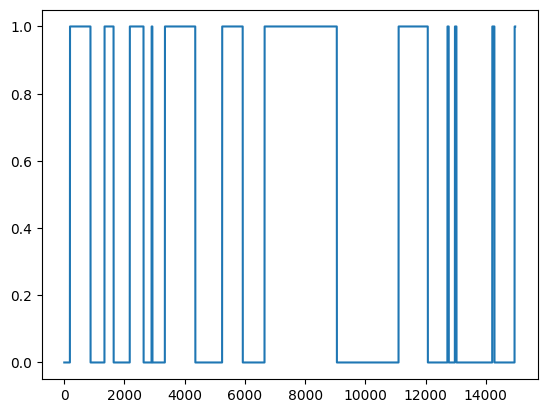

In [ ]:
df_data['label'].plot()

## Define the target variable detection in the dataset
Generate a list of indexes that hold target values

In [ ]:
import operator
def get_label_indexes(df, column_name, relate, value):
    return [i for i, x in enumerate(map(relate, df[column_name], [value]*len(df))) if x]

In [ ]:
# Define what counts as a label in your data
label_indexes = get_label_indexes(df_data, 'label', operator.add, 1)
label_indexes[0:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## Create windows of data
Can be used directly for models expecting 3D input or can be averaged over specific time periods.

### Create fixed windows of data corresponding to the target values
Can be overlapping or non-overlapping windows

In [ ]:
from typing import List, Dict, Any

def get_fixed_window_information(df: Any, label_indexes: List[int], window_width: int, future_steps: int, label_column: str, overlap: bool = False) -> List[Dict[str, int]]:
    """
    Get window information for the given DataFrame based on label_indexes.
    Uses fixed window sizes.

    Args:
        df: The DataFrame containing the data.
        label_indexes: A list of indexes representing the target values.
        window_width: The width of the sliding window.
        future_steps: The number of steps to look into the future.
        label_column: The name of the label column in the DataFrame.
        overlap: If set to True, overlapping windows will be allowed (default is False).

    Returns:
        A list of dictionaries containing window information with keys 'start_index', 'stop_index', 'label_index', and 'label_value'.
    """
    data = []
    prev_stop_index = -1

    for idx in label_indexes:
        stop_index = idx - future_steps
        start_index = stop_index - window_width

        if not overlap and start_index <= prev_stop_index:
            continue

        # Ensure the start_index is non-negative and the window size is equal to window_width
        if start_index >= 0 and stop_index - start_index == window_width:
            window_info = {
                'start_index': start_index,
                'stop_index': stop_index,
                'label_index': idx,
                'label_value': df[label_column][idx]
            }
            data.append(window_info)
            prev_stop_index = stop_index

    return data

In [ ]:
window_info = get_fixed_window_information(df_data, label_indexes, 500, 100, 'label', overlap=False)
window_info

[{'start_index': 0, 'stop_index': 500, 'label_index': 600, 'label_value': 1},
 {'start_index': 501,
  'stop_index': 1001,
  'label_index': 1101,
  'label_value': 0},
 {'start_index': 1002,
  'stop_index': 1502,
  'label_index': 1602,
  'label_value': 1},
 {'start_index': 1503,
  'stop_index': 2003,
  'label_index': 2103,
  'label_value': 0},
 {'start_index': 2004,
  'stop_index': 2504,
  'label_index': 2604,
  'label_value': 1},
 {'start_index': 2505,
  'stop_index': 3005,
  'label_index': 3105,
  'label_value': 0},
 {'start_index': 3006,
  'stop_index': 3506,
  'label_index': 3606,
  'label_value': 1},
 {'start_index': 3507,
  'stop_index': 4007,
  'label_index': 4107,
  'label_value': 1},
 {'start_index': 4008,
  'stop_index': 4508,
  'label_index': 4608,
  'label_value': 0},
 {'start_index': 4509,
  'stop_index': 5009,
  'label_index': 5109,
  'label_value': 0},
 {'start_index': 5010,
  'stop_index': 5510,
  'label_index': 5610,
  'label_value': 1},
 {'start_index': 5511,
  'stop_in

In [ ]:
600 in label_indexes

True

In [ ]:
def extract_ts_windows(window_info, df, label_col):
  ts_data_list = []
  ts_label_list = []
  labels = df[label_col]
  df = df.drop(label_col, axis=1)
  for window in window_info:
    start = window['start_index']
    end = window['stop_index']
    ts_data_list.append(df.iloc[start:end])
    ts_label_list.append(window['label_value'])
  return ts_data_list, ts_label_list

In [ ]:
X_df, y_list = extract_ts_windows(window_info, df_data, 'label')
len(X_df)

29

In [ ]:
X_df[0]

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4290.77,4000.51,4248.72,4092.31,4338.97,4615.38,4090.77,4631.28,4229.23,4230.77,4194.87,4284.10,4624.62,4357.95
496,4288.21,4006.67,4245.13,4091.79,4343.08,4620.00,4098.46,4641.03,4233.85,4241.54,4197.44,4283.59,4625.64,4350.26
497,4284.10,4001.03,4246.15,4084.10,4339.49,4624.10,4106.15,4636.41,4217.44,4233.33,4192.82,4280.51,4621.54,4338.97
498,4278.97,3995.38,4246.15,4084.10,4334.36,4619.49,4103.59,4624.10,4197.44,4217.44,4185.13,4276.41,4615.90,4334.36


In [ ]:
y_list[0]

1

### Create dynamic windows of data corresponding to the target values
Can be overlapping or non-overlapping windows

In [ ]:
df_data

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,label
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,4281.03,3990.26,4245.64,4116.92,4333.85,4614.36,4074.87,4625.64,4203.08,4221.54,4171.28,4269.23,4593.33,4340.51,1
14976,4276.92,3991.79,4245.13,4110.77,4332.82,4615.38,4073.33,4621.54,4194.36,4217.44,4162.56,4259.49,4590.26,4333.33,1
14977,4277.44,3990.77,4246.67,4113.85,4333.33,4615.38,4072.82,4623.59,4193.33,4212.82,4160.51,4257.95,4591.79,4339.49,1
14978,4284.62,3991.79,4251.28,4122.05,4334.36,4616.41,4080.51,4628.72,4200.00,4220.00,4165.64,4267.18,4596.41,4350.77,1


In [ ]:
label_indexes[:20]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

## Utilise these windows of data to train a model

### XGB Trees

In [ ]:
from xgboost import XGBRegressor
from xgboost.sklearn import XGBClassifier

In [ ]:
X_flat = [df.to_numpy().flatten() for df in X_df]

In [ ]:
len(X_flat), len(X_flat[0])

(29, 7000)

In [ ]:
X_flat[0]

array([4329.23, 4009.23, 4289.23, ..., 4272.31, 4603.59, 4327.69])

In [ ]:
train_pct = 0.60
len_train = round(len(X_flat) * train_pct)

X_train, X_test = np.split(X_flat, [int(len_train)])
y_train, y_test = np.split(y_list, [int(len_train)])

# X_train = X_flat[:len_train]
# y_train = y_list[:len_train]

len(X_train), len(y_train), len(X_test), len(y_test)

(17, 17, 12, 12)

In [ ]:
model = XGBRegressor(n_jobs=-1)
# model = XGBClassifier(n_jobs=-1)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
print(predictions)
print(list(y_test))

[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
# Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 58.33%


### RNN Approaches

In [ ]:
train_pct = 0.60
len_train = round(len(X_df) * train_pct)

X_train, X_test = np.split(X_df, [int(len_train)])
y_train, y_test = np.split(y_list, [int(len_train)])

# X_train = X_flat[:len_train]
# y_train = y_list[:len_train]

len(X_train), len(y_train), len(X_test), len(y_test)

(17, 17, 12, 12)

In [ ]:
X_train[0].shape

(500, 14)

In [ ]:
X_train.shape

(17, 500, 14)

In [ ]:
n_features = X_train.shape[2]

In [ ]:
from sklearn.preprocessing import StandardScaler

def scale_3d_data(X):
    num_samples, timesteps, n_features = X.shape
    X_scaled = np.zeros((num_samples, timesteps, n_features))
    scalers = []

    for i in range(n_features):
        scaler = StandardScaler()
        X_scaled[:, :, i] = scaler.fit_transform(X[:, :, i])
        scalers.append(scaler)

    return X_scaled, scalers

X_train_scaled, scalers = scale_3d_data(X_train)
X_test_scaled = np.zeros_like(X_test)

for i in range(n_features):
    X_test_scaled[:, :, i] = scalers[i].transform(X_test[:, :, i])
X_train_scaled.shape, X_test_scaled.shape

((17, 500, 14), (12, 500, 14))

#### LSTM

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Input, LSTM, Dropout, Dense

LOOK_BACK = 500
FORECAST_RANGE = 100

input_layer = Input(shape=(LOOK_BACK, n_features))

# Regulariser applied to prevent overfitting and improve generalisation
lstm = LSTM(500, activation='relu', kernel_regularizer=l2(0.01))(input_layer)

dropout = Dropout(0.2)(lstm)
dense = Dense(1, activation='linear')(dropout)

model = Model(inputs=input_layer, outputs=dense)
# Clipvalue helps prevent exploding gradients
model.compile(optimizer=Adam(clipvalue=1.0), loss='mse')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500, 14)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 500)               1030000   
                                                                 
 dropout_8 (Dropout)         (None, 500)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 501       
                                                                 
Total params: 1,030,501
Trainable params: 1,030,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
1/1 [==============================] - 5s 5s/step - loss: 0.6940 - val_loss: 0.8553
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 0.4799 - val_loss: 0.5673
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 0.3838 - val_loss: 0.4389
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 0.4040 - val_loss: 0.4409
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 0.3353 - val_loss: 0.5040


In [ ]:
y_pred = model.predict(X_test_scaled)
predictions = y_pred
print(predictions.flatten())
print([round(x) for x in predictions.flatten()])
print(list(y_test))

1/1 [==============================] - 1s 601ms/step
[8.4649843e-01 3.7822881e-01 2.6903397e-01 2.3748325e+05 1.5003524e+14
 2.1735640e+03 4.0160147e+08 3.5970062e-01 3.9116716e-01 1.2000152e+10
 7.7965564e-01 4.0379828e-01]
[1, 0, 0, 237483, 150035236913152, 2174, 401601472, 0, 0, 12000151552, 1, 0]
[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
# Evaluate predictions
accuracy = accuracy_score(y_test, [round(x) for x in predictions.flatten()])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 41.67%


#### LSTM-CNN

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Input, Conv1D, Flatten, Concatenate, Reshape, LSTM, Dropout, Dense

LOOK_BACK = 500
FORECAST_RANGE = 100

input_layer = Input(shape=(LOOK_BACK, n_features))

head_list = []
for i in range(n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation='relu')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)

concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)

# Regulariser applied to prevent overfitting and improve generalisation
lstm = LSTM(100, activation='relu', kernel_regularizer=l2(0.01))(reshape)

dropout = Dropout(0.2)(lstm)
dense = Dense(1, activation='linear')(dropout)

model = Model(inputs=input_layer, outputs=dense)
# Clipvalue helps prevent exploding gradients
model.compile(optimizer=Adam(clipvalue=1.0), loss='mse')
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 500, 14)]    0           []                               
                                                                                                  
 conv1d_28 (Conv1D)             (None, 494, 4)       396         ['input_5[0][0]']                
                                                                                                  
 conv1d_30 (Conv1D)             (None, 494, 4)       396         ['input_5[0][0]']                
                                                                                                  
 conv1d_32 (Conv1D)             (None, 494, 4)       396         ['input_5[0][0]']                
                                                                                            

In [ ]:
model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
1/1 [==============================] - 8s 8s/step - loss: 0.7804 - val_loss: 1.2570
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 0.7375 - val_loss: 1.1869
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 0.6808 - val_loss: 1.1195
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 0.6274 - val_loss: 1.0503
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 0.5879 - val_loss: 0.9773


In [ ]:
y_pred = model.predict(X_test_scaled)
predictions = y_pred
print(predictions.flatten())
print([round(x) for x in predictions.flatten()])
print(list(y_test))

1/1 [==============================] - 1s 923ms/step
[1.5216948e-01 2.9117373e-01 1.8157606e-01 7.9393021e+12 3.0069442e+07
 4.0127354e+23 2.0432909e+14 7.5623199e-02 1.1687829e-01 6.2886824e+14
 1.1227809e-01 7.0691176e-02]
[0, 0, 0, 7939302096896, 30069442, 401273537044878672789504, 204329092907008, 0, 0, 628868239065088, 0, 0]
[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
# # Evaluate predictions - Fails because of outputs being too far offS
# accuracy = accuracy_score(y_test, [round(x) for x in predictions.flatten()])
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

### Transformer Encoder only

#### Custom Transformer Architecture

In [ ]:
import tensorflow as tf

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
  class PositionalEmbedding(tf.keras.layers.Layer):
      def __init__(self, *, vocab_size, d_model):
          super(PositionalEmbedding, self).__init__()
          self.d_model = d_model
          self.pos_encoding = self.positional_encoding(vocab_size, d_model)

      def positional_encoding(self, position, d_model):
          angle_rads = self.get_angles(
              np.arange(position)[:, np.newaxis],
              np.arange(d_model)[np.newaxis, :],
              d_model)
          angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
          angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
          pos_encoding = angle_rads[np.newaxis, ...]
          return tf.cast(pos_encoding, dtype=tf.float32)

      def get_angles(self, pos, i, d_model):
          angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
          return pos * angle_rates

      def call(self, x):
          length = tf.shape(x)[1]
          x = x * tf.math.sqrt(tf.cast(self.d_model, tf.float32))
          x = x + self.pos_encoding[:, :length, :tf.shape(x)[-1]]
          return x


In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`

#### Train Transformer

In [ ]:
class CustomTransformer(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate):
        super(CustomTransformer, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.encoder = Encoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            vocab_size=input_vocab_size,
            dropout_rate=dropout_rate
        )

    def call(self, x):
        context = self.encoder(x)  # (batch_size, context_len, d_model)
        return context


In [ ]:
from keras.layers import GlobalAveragePooling1D

LOOK_BACK = 500
n_features = 14
# Vocab size - here determines the number of positional encoding steps possible
input_vocab_size = 4000

input_layer = Input(shape=(LOOK_BACK, n_features))

# Create the custom transformer model
custom_transformer = CustomTransformer(
    num_layers=4,
    d_model=n_features,
    num_heads=4,
    dff=512,
    input_vocab_size=input_vocab_size,
    dropout_rate=0.1
)

# Apply the custom transformer model to the input
transformer_output = custom_transformer(input_layer)

# Add a dropout layer
dropout = Dropout(0.2)(transformer_output)

# Add a global average pooling layer
global_avg_pool = GlobalAveragePooling1D()(dropout)

# Add a dense layer with one unit and a linear activation function
dense = Dense(1, activation='linear')(global_avg_pool)

# Create the final model
model = Model(inputs=input_layer, outputs=dense)
model.compile(optimizer=Adam(clipvalue=1.0), loss='mse')
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500, 14)]         0         
                                                                 
 custom_transformer (CustomT  (None, 500, 14)          72944     
 ransformer)                                                     
                                                                 
 dropout_7 (Dropout)         (None, 500, 14)           0         
                                                                 
 global_average_pooling1d (G  (None, 14)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_10 (Dense)            (None, 1)                 15        
                                                                 
Total params: 72,959
Trainable params: 72,959
Non-trainable

In [ ]:
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
1/1 [==============================] - 9s 9s/step - loss: 0.6768 - val_loss: 0.6159
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 0.4341 - val_loss: 0.7975
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 0.1045 - val_loss: 1.2371
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 0.1299 - val_loss: 1.3984
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.1616 - val_loss: 1.2229
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.1236 - val_loss: 0.9113
Epoch 7/100
1/1 [==============================] - 3s 3s/step - loss: 0.0307 - val_loss: 0.6573
Epoch 8/100
1/1 [==============================] - 4s 4s/step - loss: 0.0181 - val_loss: 0.4987
Epoch 9/100
1/1 [==============================] - 2s 2s/step - loss: 0.0429 - val_loss: 0.4293
Epoch 10/100
1/1 [==============================] - 2s 2s/step - loss: 0.0478 - val_loss: 0.4130
Epoch 11/100
1/1 [=====================

In [ ]:
y_pred = model.predict(X_test_scaled)
predictions = y_pred
print(predictions.flatten())
print([round(x) for x in predictions.flatten()])
print(list(y_test))

1/1 [==============================] - 2s 2s/step
[ 0.51068425  0.48225656  0.5615767  -0.15397441 -0.19487841  0.65444374
 -0.03307545 -0.03261497  0.29188898  0.7195349   0.11552685  0.47769907]
[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
# Evaluate predictions
accuracy = accuracy_score(y_test, [round(x) for x in predictions.flatten()])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 66.67%


# TODO
Think about what to do when we want to use all data since a reading.
* Could change window creation to enforce that we use all data between windows with no overlap

https://www.phind.com/search?cache=ae7afb8b-5f42-431a-b6d8-0c6dd76f4a5d

In [ ]:
def create_windows(data, y_indices, forecast_range, overlap=False):
    windows = []
    prev_end = 0
    for i in range(len(y_indices) - 1):
        start = y_indices[i] if overlap else max(y_indices[i], prev_end)
        end = y_indices[i + 1] - forecast_range
        window = data[start:end]
        windows.append(window)
        prev_end = end + 1
    return np.array(windows)

windows = create_windows(df_data, label_indexes, 100, overlap=False)

<ipython-input-57-0bbb6d8f0f2f>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(windows)


In [ ]:
from typing import List, Dict, Any

from typing import List, Dict, Any

def get_window_information(df: Any, label_indexes: List[int], future_steps: int, label_column: str, overlap: bool = False) -> List[Dict[str, int]]:
    """
    Get window information for the given DataFrame based on label_indexes.

    Args:
        df: The DataFrame containing the data.
        label_indexes: A list of indexes representing the target values.
        future_steps: The number of steps to look into the future.
        label_column: The name of the label column in the DataFrame.
        overlap: If set to True, overlapping windows will be allowed (default is False).

    Returns:
        A list of dictionaries containing window information with keys 'start_index', 'stop_index', 'label_index', and 'label_value'.
    """
    data = []
    prev_stop_index = -1

    for i in range(len(label_indexes) - 1):
        start_index = label_indexes[i]
        stop_index = label_indexes[i + 1] - future_steps

        if not overlap and stop_index <= prev_stop_index:
            continue

        # Ensure the start_index is non-negative
        if start_index >= 0:
            window_info = {
                'start_index': start_index,
                'stop_index': stop_index,
                'label_index': start_index,
                'label_value': df[label_column][start_index]
            }
            data.append(window_info)
            prev_stop_index = stop_index

    return data


windows = get_window_information(df_data, label_indexes, 100, 'label', overlap=False)

In [ ]:
label_indexes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
windows[0]

{'start_index': 99, 'stop_index': 0, 'label_index': 99, 'label_value': 0}

In [ ]:
windows[1]

{'start_index': 100, 'stop_index': 1, 'label_index': 100, 'label_value': 0}

In [ ]:
from sklearn.preprocessing import StandardScaler

def pad_windows(windows, max_length):
    padded_windows = []
    for window in windows:
        padding = max_length - window.shape[0]
        pad = np.zeros((padding, window.shape[1]))
        padded_window = np.vstack((window, pad))
        padded_windows.append(padded_window)
    return np.array(padded_windows)

max_length = max([window.shape[0] for window in windows])
windows_padded = pad_windows(windows, max_length)

scaler = StandardScaler()
windows_padded_scaled = np.zeros(windows_padded.shape)

for i in range(windows_padded.shape[0]):
    windows_padded_scaled[i] = scaler.fit_transform(windows_padded[i])


AttributeError: ignored